# 🤖 AI Agents Demo: Autonomous Data Cleaning & EDA

Welcome! In this notebook we'll see AI agents in action — not just chatting, but **doing real work**.

We'll go step by step:
1. What's an LLM? (quick recap)
2. What makes an agent different from a chatbot?
3. Explore each piece of our data agent
4. Run the full agent pipeline on a real CSV

No prior AI experience needed. If you can read Python, you're good.

---
## Part 1: Setup

First, let's make sure everything is installed. Run the cell below once.

In [1]:
# If running in Colab or a fresh environment, uncomment and run:
# !pip install langchain langgraph langchain-openai langchain-anthropic langchain-groq langchain-aws pandas matplotlib seaborn chardet

In [2]:
import os
import pandas as pd
import json

# Set your API key here (pick ONE provider)
# Option A: OpenAI
# os.environ["OPENAI_API_KEY"] = "sk-..."

# Option B: Anthropic
# os.environ["ANTHROPIC_API_KEY"] = "sk-ant-..."

# Option C: Groq (free tier available)
# os.environ["GROQ_API_KEY"] = "gsk_..."

# Option D: AWS Bedrock — uses your AWS credentials, no key needed here

print("Setup complete")

Setup complete


---
## Part 2: Quick LLM Recap

An LLM (Large Language Model) is an AI trained on massive amounts of text. 
It predicts the next word — but does it so well that it can write code, answer questions, and reason about problems.

Let's see one in action:

In [3]:
# !aws sso login

In [4]:
from src.llm_config import get_llm

# Change provider/model to match your API key
# Options: "openai", "anthropic", "groq", "bedrock"
PROVIDER = "bedrock"

# For Bedrock, also pass region_name:
# llm = get_llm(provider="bedrock", region_name="eu-north-1")
llm = get_llm(provider=PROVIDER)

print(f"Using provider: {PROVIDER}")

/Users/apple/Developer/olink/EDAcleanr/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


Using provider: bedrock


In [5]:
# A simple LLM call — just a chatbot, not an agent yet
response = llm.invoke("What are the 3 most common problems in messy CSV files? Be brief.")
print(response.content)

1. Inconsistent delimiters.
2. Missing or extra quotes.
3. Irregular data formatting.


That's a **chatbot**: you ask, it answers. One shot.

An **agent** goes further — it gets a goal, thinks about what to do, uses tools, checks results, and loops until done.

```
Agent = LLM + Tools + Memory + Reasoning Loop
```

Let's build up to that.

---
## Part 3: Load a Messy CSV

Our agent's first job: load a CSV file. This sounds simple, but real-world CSVs have encoding issues, weird delimiters, and other surprises.

Our loader handles all of that automatically.

In [6]:
from src.csv_loader import load_csv

# Point this to your CSV file
CSV_PATH = "../../../Downloads/archive/animal_data_dirty1.csv"  # <-- change this!

result = load_csv(CSV_PATH)

if result["error"]:
    print(f"Error: {result['error']}")
else:
    df = result["df"]
    print(f"Loaded successfully!")
    print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
    print(f"Columns: {list(df.columns)}")
    df.head()

Loaded successfully!
Shape: 1011 rows x 11 columns
Columns: ['Animal type', 'Country', 'Weight kg', 'Body Length cm', 'Gender', 'Animal code', 'Latitude', 'Longitude', 'Animal name', 'Observation date', 'Data compiled by']


---
## Part 4: Inspect — What's Wrong With This Data?

Before cleaning, we need to know what's broken. Our inspection tools check for:
- Missing values (per column)
- Duplicate rows
- Outliers (using the IQR method)
- Mixed types in columns (numbers and text mixed together)
- High cardinality (too many unique values in a category)
- Zero variance columns (same value everywhere — useless)

In [7]:
from src.tools.inspection import detect_issues, get_df_info

# Profile the data
profile = get_df_info(df)
print(profile[:1000])  # first 1000 chars to keep it readable
print("\n... (truncated)")

Shape: 1011 rows x 11 columns

Column Data Types:
  Animal type: str
  Country: str
  Weight kg: float64
  Body Length cm: float64
  Gender: str
  Animal code: float64
  Latitude: float64
  Longitude: float64
  Animal name: str
  Observation date: str
  Data compiled by: str

First 10 rows:
       Animal type  Country  Weight kg  Body Length cm          Gender  Animal code   Latitude  Longitude Animal name Observation date Data compiled by
0              NaN      NaN        NaN             NaN             NaN          NaN        NaN        NaN         NaN       03.01.2024    James Johnson
1              NaN      NaN        NaN             NaN             NaN          NaN        NaN        NaN         NaN       03.02.2024    James Johnson
2   European bison   Poland    930.000           335.0            male          NaN  52.828845  23.820144       Szefu       01.03.2024     Anne Anthony
3   European bison   Poland    909.000           311.0  not determined          NaN  52.830509  23.8

In [8]:
# Detect all issues
issues = detect_issues(df)

print("=== Issue Report ===")
print("\nMissing values (% per column):")
for col, pct in issues["missing_pct"].items():
    if pct > 0:
        print(f"  {col}: {pct:.1f}%")

print(f"\nDuplicate rows: {issues['duplicate_count']}")

print("\nOutliers (IQR method):")
for col, indices in issues["outliers"].items():
    print(f"  {col}: {len(indices)} outlier(s)")

if issues["inconsistent_types"]:
    print(f"\nMixed types: {issues['inconsistent_types']}")

if issues["zero_variance"]:
    print(f"\nZero variance: {issues['zero_variance']}")

if issues["high_cardinality"]:
    print(f"\nHigh cardinality: {issues['high_cardinality']}")

=== Issue Report ===

Missing values (% per column):
  Animal type: 2.0%
  Country: 1.2%
  Weight kg: 2.7%
  Body Length cm: 2.7%
  Gender: 1.9%
  Animal code: 100.0%
  Latitude: 9.7%
  Longitude: 9.7%
  Animal name: 94.9%

Duplicate rows: 167

Outliers (IQR method):
  Weight kg: 134 outlier(s)
  Body Length cm: 147 outlier(s)
  Latitude: 6 outlier(s)
  Longitude: 4 outlier(s)

Zero variance: ['Animal code']


---
## Part 5: Clean — Fix the Problems

Now we use our cleaning tools. In the full agent, the LLM decides which tools to call and in what order. 
Here we'll try them manually so you can see what each one does.

In [9]:
from src.tools.cleaning import (
    drop_duplicates,
    fill_missing,
    normalize_columns,
    strip_string_values,
    drop_useless_columns,
    remove_outliers,
)

# Start with a copy
cleaned = df.copy()
print(f"Starting shape: {cleaned.shape}")

Starting shape: (1011, 11)


In [10]:
# Step 1: Normalize column names (lowercase, strip whitespace)
cleaned, log = normalize_columns(cleaned)
print(log.description)

Normalized 11 column name(s): 'Animal type' -> 'animal type', 'Country' -> 'country', 'Weight kg' -> 'weight kg', 'Body Length cm' -> 'body length cm', 'Gender' -> 'gender', 'Animal code' -> 'animal code', 'Latitude' -> 'latitude', 'Longitude' -> 'longitude', 'Animal name' -> 'animal name', 'Observation date' -> 'observation date', 'Data compiled by' -> 'data compiled by'


In [11]:
# Step 2: Strip whitespace from string values
cleaned, log = strip_string_values(cleaned)
print(log.description)

Stripped whitespace from 6 string column(s).


In [12]:
# Step 3: Remove duplicate rows
cleaned, log = drop_duplicates(cleaned)
print(log.description)
print(f"Shape after dedup: {cleaned.shape}")

Removed 167 duplicate rows.
Shape after dedup: (844, 11)


In [13]:
# Step 4: Drop useless columns (>90% missing or zero variance)
cleaned, log = drop_useless_columns(cleaned)
print(log.description)
print(f"Shape after dropping useless columns: {cleaned.shape}")

Dropped 2 useless column(s): animal code, animal name
Shape after dropping useless columns: (844, 9)


In [14]:
# Step 5: Fill missing values in numeric columns with median
import numpy as np

numeric_cols = cleaned.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if cleaned[col].isna().sum() > 0:
        cleaned, log = fill_missing(cleaned, col, "median")
        print(log.description)

print(f"\nRemaining missing values: {cleaned.isna().sum().sum()}")

Filled missing values in 'weight kg' using median strategy.
Filled missing values in 'body length cm' using median strategy.
Filled missing values in 'latitude' using median strategy.
Filled missing values in 'longitude' using median strategy.

Remaining missing values: 45


Each tool returns the cleaned DataFrame plus a log entry describing what it did. 
The agent collects all these logs for the final report.

---
## Part 6: EDA — Explore the Clean Data

Now that the data is cleaner, let's analyze it.

In [15]:
from src.tools.eda import describe_numeric, describe_categorical, compute_correlation, generate_plots

# Numeric statistics
print("=== Numeric Statistics ===")
print(describe_numeric(cleaned))

=== Numeric Statistics ===
         weight kg  body length cm    latitude   longitude
count   844.000000      844.000000  844.000000  844.000000
mean     46.290358       42.200237   49.238873   17.772974
std     167.874269       62.741228    6.947500    3.772801
min      -0.252000      -19.000000  -78.582973   11.074008
25%       0.298750       19.000000   48.228756   14.382216
50%       0.350000       21.000000   49.057679   18.849445
75%       0.900000       23.000000   50.643518   20.558680
max    1100.000000      350.000000   52.853843   34.896734


In [16]:
# Categorical statistics (top 10 values per column)
print("=== Categorical Statistics ===")
print(describe_categorical(cleaned))

=== Categorical Statistics ===
Column: animal type
animal type
red squirrel       387
hedgehog           274
lynx                61
European bison      49
red squirrell       16
lynx?               10
red squirel         10
European bison™      6
European bisson      4
European buster      4

Column: country
country
Poland            182
Germany           173
Slovakia          151
Hungary           103
Czech Republic    103
Austria            74
PL                 10
HU                  8
Hungry              7
CZ                  5

Column: gender
gender
male              423
female            401
not determined      5

Column: observation date
observation date
01.03.2024    49
02.03.2024    45
06.04.2024    43
02.04.2024    36
04.03.2024    27
24.03.2024    26
21.03.2024    25
07.03.2024    21
05.04.2024    19
08.04.2024    19

Column: data compiled by
data compiled by
Anne Anthony     310
Bob Bobson       256
John Johnson     249
James Johnson     29


In [17]:
# Correlation matrix
print("=== Correlation Matrix ===")
print(compute_correlation(cleaned))

=== Correlation Matrix ===
                weight kg  body length cm  latitude  longitude
weight kg        1.000000        0.946469  0.096744   0.270548
body length cm   0.946469        1.000000  0.077006   0.308109
latitude         0.096744        0.077006  1.000000   0.049117
longitude        0.270548        0.308109  0.049117   1.000000


In [18]:
cleaned

,animal type,country,weight kg,body length cm,gender,latitude,longitude,observation date,data compiled by
0,NaN,NaN,0.350,21.0,NaN,49.057679,18.849445,03.01.2024,James Johnson
1,NaN,NaN,0.350,21.0,NaN,49.057679,18.849445,03.02.2024,James Johnson
2,European bison,Poland,930.000,335.0,male,52.828845,23.820144,01.03.2024,Anne Anthony
3,European bison,Poland,909.000,311.0,not determined,52.830509,23.826849,01.03.2024,Anne Anthony
4,European bison™,Poland,581.000,277.0,female,52.834109,23.807093,01.03.2024,Anne Anthony
...,...,...,...,...,...,...,...,...,...
839,hedgehog,Hungary,0.900,23.0,male,47.510055,18.944356,7 May 2024,Anne Anthony
840,red squirrel,Poland,0.346,20.0,female,52.212001,21.033187,7 May 2024,Anne Anthony
841,hedgehog,Germany,1.000,23.0,female,49.561356,11.105334,7 May 2024,Bob Bobson
842,hedgehog,Germany,0.500,17.0,female,49.561569,11.087046,7 May 2024,Bob Bobson


Generated 9 figures

Hist Weight Kg


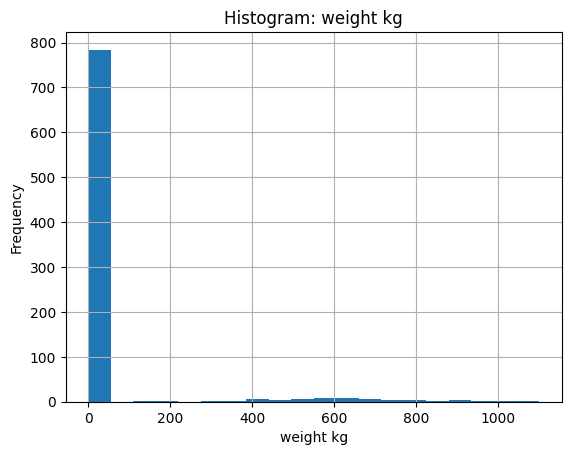


Hist Body Length Cm


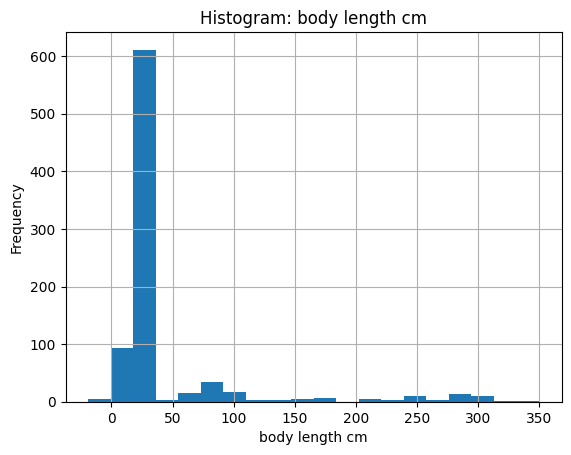


Hist Latitude


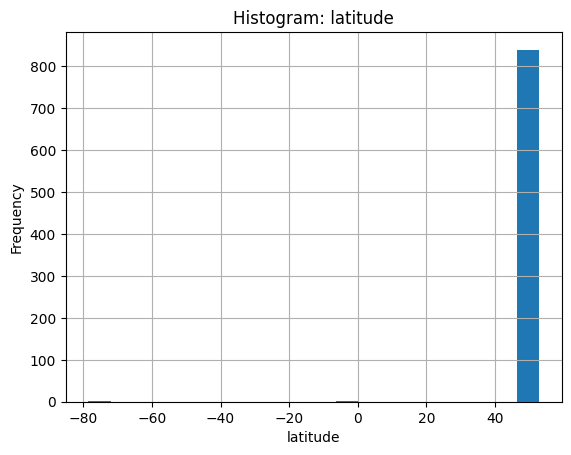


Hist Longitude


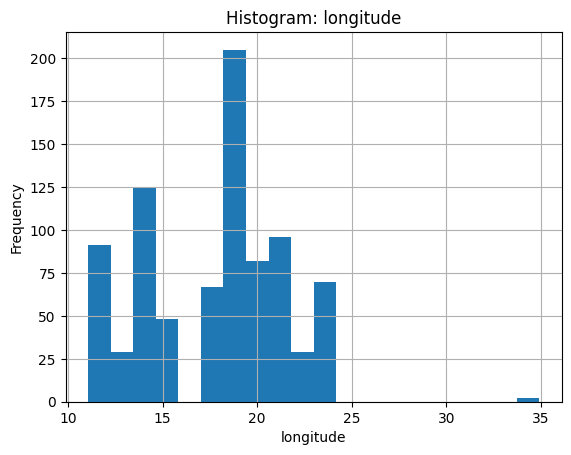


Box Weight Kg


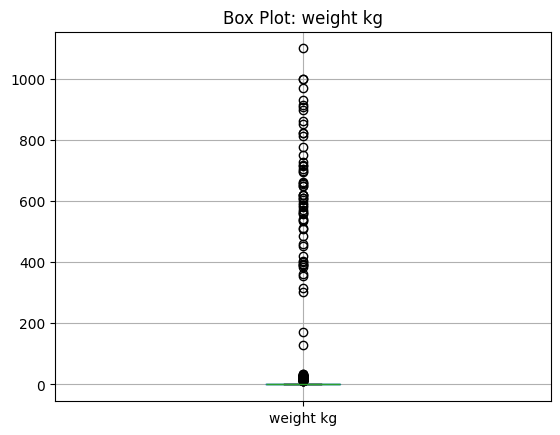


Box Body Length Cm


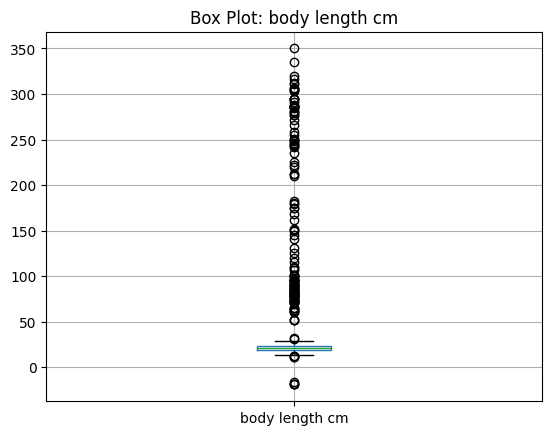


Box Latitude


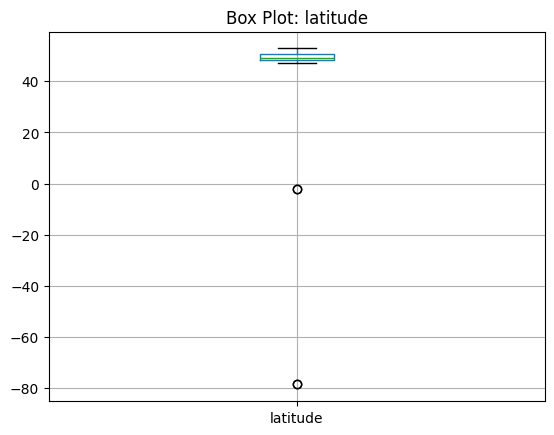


Box Longitude


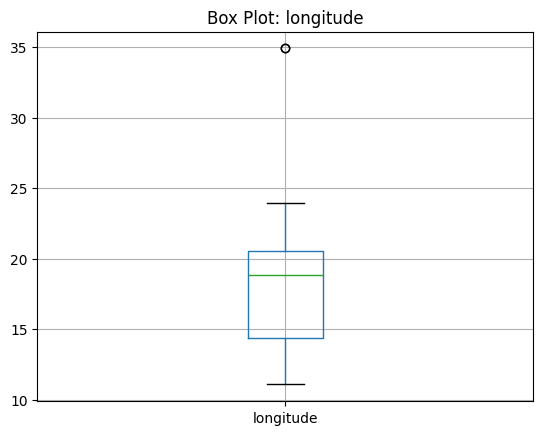


Correlation Heatmap


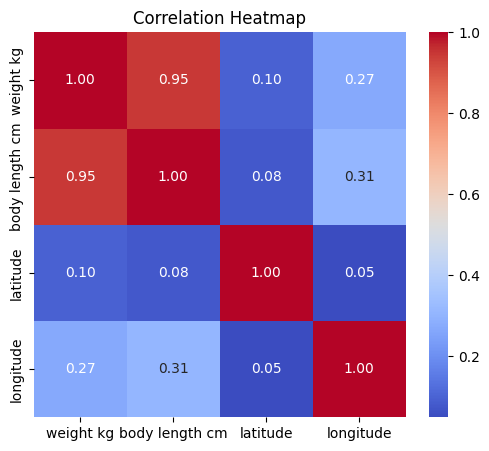

In [19]:
# Generate and display plots
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pathlib import Path

fig_paths = generate_plots(cleaned, "output/figures")
print(f"Generated {len(fig_paths)} figures\n")

# Show the plots inline
for path in fig_paths:
    print(Path(path).stem.replace('_', ' ').title())
    display(Image(filename=path, width=500))
    print()

---
## Part 7: The Full Agent — Putting It All Together

So far we called each tool manually. The real power of an agent is that the **LLM decides** what to do.

Our LangGraph workflow connects all the pieces:

```
Load CSV -> Inspect -> Decide Cleaning -> Clean (loop) -> EDA -> Report
```

The LLM:
- Reviews the issue report and decides which cleaning tools to call
- Can loop back for more cleaning if needed
- Analyzes EDA results and writes insights

This is the **ReAct pattern**: Reason + Act, in a loop.

In [20]:
from src.graph import build_graph
from src.models import AgentState

# Build the agent graph
graph = build_graph(llm)

# Prepare the initial state
initial_state: AgentState = {
    "file_path": CSV_PATH,
    "cleaning_iteration": 0,
    "max_cleaning_iterations": 3,
    "cleaning_log": [],
    "errors": [],
    "reasoning_log": [],
    "insights": [],
    "figure_paths": [],
    "needs_more_cleaning": False,
    "df": None,
    "original_shape": None,
    "profile": None,
    "issue_report": None,
    "eda_results": None,
    "report_path": None,
}

print("Running the full agent pipeline...")
print("(This may take 30-60 seconds depending on the LLM)\n")

result = graph.invoke(initial_state)

Running the full agent pipeline...
(This may take 30-60 seconds depending on the LLM)



In [21]:
result

{'file_path': '../../../Downloads/archive/animal_data_dirty1.csv',
 'df':           Animal type  Country  Weight kg  Body Length cm          Gender  \
 0                 NaN      NaN        NaN             NaN             NaN   
 1                 NaN      NaN        NaN             NaN             NaN   
 2      European bison   Poland    930.000           335.0            male   
 3      European bison   Poland    909.000           311.0  not determined   
 4     European bison™   Poland    581.000           277.0          female   
 ...               ...      ...        ...             ...             ...   
 1006     red squirrel   Poland      0.346            20.0          female   
 1007         hedgehog  Germany      1.000            23.0          female   
 1008         hedgehog  Germany      0.500            17.0          female   
 1009     red squirrel   Poland      0.346            20.0          female   
 1010         hedgehog  Hungary      0.900            16.0          f

In [22]:
# Check results
if result.get("report_path"):
    print(f"Report saved to: {result['report_path']}")
else:
    print("Report was not generated.")

if result.get("errors"):
    print(f"\nErrors encountered: {len(result['errors'])}")
    for err in result["errors"]:
        print(f"  - {err}")

Report saved to: output/report.md


In [23]:
# View the agent's reasoning log — this shows HOW the agent thought
print("=== Agent Reasoning Log ===")
for entry in result.get("reasoning_log", []):
    agent = entry.get("agent", "unknown")
    reasoning = entry.get("reasoning", "")[:200]  # truncate for readability
    print(f"\n[{agent}]")
    print(f"  {reasoning}")
    if len(entry.get("reasoning", "")) > 200:
        print("  ...")

=== Agent Reasoning Log ===

[load_csv_node]
  Successfully loaded CSV with shape (1011, 11).

[inspect_node]
  [{'type': 'text', 'text': '<thinking> To inspect the dataset and report all issues, I will first use the `inspect_profile` tool to get an overview of the dataset. Then, I will use the `inspect_issues`
  ...

[clean_decision_node]
  ```json
{
  "needs_cleaning": true,
  "plan": "The data requires cleaning due to several issues identified in the report. The plan includes:\n1. Handling missing values for columns 'Animal type', 'Cou
  ...

[clean_node]
  Iteration 1: [{'type': 'text', 'text': "<thinking> Based on the detected issues, the following steps will be taken to clean the dataset:\n1. Drop duplicate rows to remove redundancy.\n2. Fill missing 
  ...

[eda_node]
  [{'type': 'text', 'text': '<thinking> To analyze the cleaned dataset and provide insights, I need to gather statistics and correlations from the dataset. I will start by using the `eda_numeric_stats` 
  ...

[rep

In [24]:
# Display the generated report
from IPython.display import Markdown

if result.get("report_path"):
    with open(result["report_path"], "r") as f:
        report_content = f.read()
    display(Markdown(report_content))
else:
    print("No report to display.")

# Data Cleaning & EDA Report

## Dataset Overview

- **Original shape**: 1011 rows × 11 columns
- **Cleaned shape**: 1011 rows × 11 columns
- **Rows removed**: 0
- **Columns removed**: 0

## Issues Found

### Missing Values

| Column | Missing % |
|--------|-----------|
| Animal type | 2.0% |
| Country | 1.2% |
| Weight kg | 2.7% |
| Body Length cm | 2.7% |
| Gender | 1.9% |
| Animal code | 100.0% |
| Latitude | 9.7% |
| Longitude | 9.7% |
| Animal name | 94.9% |
| Observation date | 0.0% |
| Data compiled by | 0.0% |

### Duplicate Rows

- **167** duplicate rows detected

### Outliers

| Column | Outlier Count |
|--------|---------------|
| Weight kg | 134 |
| Body Length cm | 147 |
| Latitude | 6 |
| Longitude | 4 |

### Zero Variance Columns

- Animal code

## Cleaning Actions

No cleaning actions were performed.


## Key Statistics

### Numeric Statistics

```
         Weight kg  Body Length cm  Animal code    Latitude   Longitude
count   984.000000      984.000000          0.0  913.000000  913.000000
mean     39.745503       39.107724          NaN   49.393369   18.203280
std     156.290076       58.628601          NaN    7.168900    3.899601
min      -0.252000      -19.000000          NaN  -78.582973   11.074008
25%       0.293000       19.000000          NaN   48.186913   14.384559
50%       0.331500       21.000000          NaN   49.560723   18.944015
75%       0.800000       23.000000          NaN   52.212433   21.033243
max    1100.000000      350.000000          NaN   52.853843   34.896734
```

### Categorical Statistics

```
Column: Animal type
Animal type
red squirrel       543
hedgehog           274
lynx                61
European bison      49
red squirrell       22
red squirel         14
lynx?               10
European bison™      6
European bisson      4
European buster      4

Column: Country
Country
Poland            291
Germany           176
Slovakia          151
Hungary           146
Czech Republic    103
Austria            74
PL                 15
HU                 11
Hungry             10
CZ                  5

Column: Gender
Gender
male              499
female            488
not determined      5

Column: Animal name
Animal name
Bob Bobson    18
Basia         10
Lola           9
Lolek          4
Zuzia          4
Sissi          2
Puchatek       2
Szefu          1
Klucha         1
Bibi           1

Column: Observation date
Observation date
01.03.2024    61
02.03.2024    47
06.04.2024    45
04.03.2024    43
02.04.2024    41
21.03.2024    28
24.03.2024    28
07.03.2024    25
11.03.2024    23
08.04.2024    20

Column: Data compiled by
Data compiled by
Anne Anthony     473
Bob Bobson       259
John Johnson     249
James Johnson     30
```

### Correlation Matrix

```
                Weight kg  Body Length cm  Animal code  Latitude  Longitude
Weight kg        1.000000        0.946319          NaN  0.084595   0.224579
Body Length cm   0.946319        1.000000          NaN  0.065909   0.253616
Animal code           NaN             NaN          NaN       NaN        NaN
Latitude         0.084595        0.065909          NaN  1.000000   0.009833
Longitude        0.224579        0.253616          NaN  0.009833   1.000000
```

## Insights

1. [{'type': 'text', 'text': '<thinking> To analyze the cleaned dataset and provide insights, I need to gather statistics and correlations from the dataset. I will start by using the `eda_numeric_stats` and `eda_categorical_stats` tools to get descriptive statistics and value counts for the columns. Then, I will use the `eda_correlation` tool to get the correlation matrix. Finally, I will use the `eda_figures` tool to get any generated figures that might provide additional insights. </thinking>\n'}, {'type': 'tool_use', 'name': 'eda_numeric_stats', 'input': {}, 'id': 'tooluse_Z06yBCACK4i6gtsyGS3BMZ'}, {'type': 'tool_use', 'name': 'eda_categorical_stats', 'input': {}, 'id': 'tooluse_awWdm7pSqIWD7lV8K2jz5a'}, {'type': 'tool_use', 'name': 'eda_correlation', 'input': {}, 'id': 'tooluse_oBUJ79OrMbVz3sY1Tb5S3R'}, {'type': 'tool_use', 'name': 'eda_figures', 'input': {}, 'id': 'tooluse_mUgMujopyAuRXEqL2RYyJT'}]

## Figures

![Hist Weight Kg](figures/hist_Weight kg.png)

![Hist Body Length Cm](figures/hist_Body Length cm.png)

![Hist Animal Code](figures/hist_Animal code.png)

![Hist Latitude](figures/hist_Latitude.png)

![Hist Longitude](figures/hist_Longitude.png)

![Box Weight Kg](figures/box_Weight kg.png)

![Box Body Length Cm](figures/box_Body Length cm.png)

![Box Animal Code](figures/box_Animal code.png)

![Box Latitude](figures/box_Latitude.png)

![Box Longitude](figures/box_Longitude.png)

![Correlation Heatmap](figures/correlation_heatmap.png)


---
## Part 8: What Just Happened?

Let's recap what the agent did **autonomously**:

1. **Loaded** the CSV (handled encoding, delimiters)
2. **Inspected** the data (found missing values, duplicates, outliers, etc.)
3. **Decided** what to clean (the LLM reviewed the issues and made a plan)
4. **Cleaned** the data (called the right tools with the right parameters)
5. **Analyzed** the clean data (statistics, correlations, charts)
6. **Wrote** a report with insights

You didn't tell it *how* to clean — it figured that out from the data.

That's the difference between a chatbot and an agent.

---
## Part 9: Try It Yourself

Things to experiment with:

- **Different CSV files** — change `CSV_PATH` above and re-run
- **Different LLM providers** — change `PROVIDER` to `"anthropic"`, `"groq"`, or `"bedrock"`
- **More cleaning iterations** — change `max_cleaning_iterations` to 5
- **From the command line** — run in your terminal:

```bash
uv run eda-agent your_data.csv --provider openai
```

---
## Limits & Gotchas

Agents are powerful but not perfect:

- **Hallucinations** — the LLM might suggest cleaning steps that don't make sense
- **Cost** — each run makes several LLM API calls (a few cents with GPT-4o-mini, more with larger models)
- **Unsafe code** — in production, you'd want sandboxing around any LLM-generated code
- **Not deterministic** — running twice on the same data may produce slightly different results

These are active research areas. The tech is moving fast.